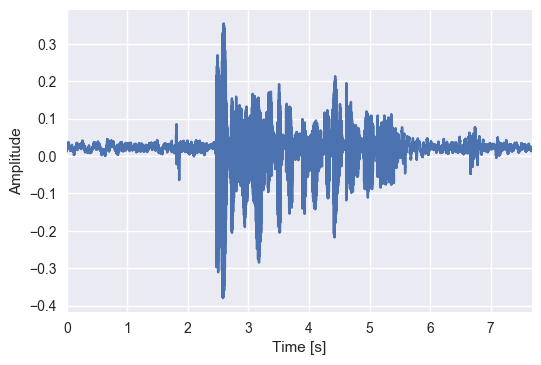

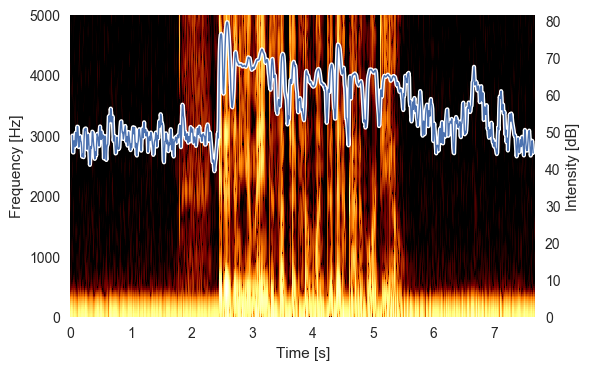

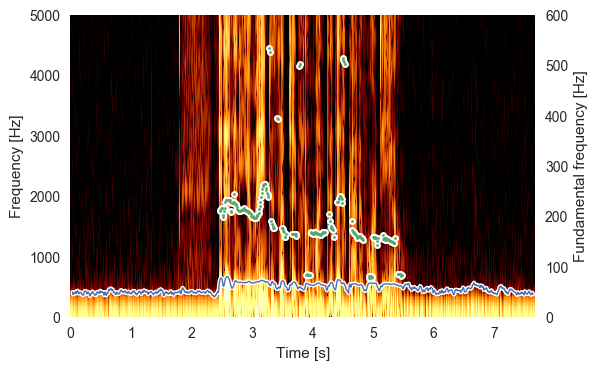

In [42]:
# Parselmouth functionalities (from Praat): waveform, spectrogram, pitch, intensity

import parselmouth

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Use seaborn's default style to make attractive graphs
plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this notebook

def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("Intensity [dB]")

def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("Fundamental frequency [Hz]")
    
snd = parselmouth.Sound("Desktop/audioclips/reduced/test_0001.wav")
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show() 

intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

pitch = snd.to_pitch()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.show()


In [33]:
# the my-voice-analysis and my-prosody libraries have many helpful features such as automated syllable detection,
# but they have very strict requirements for input audio files, and our corpus samples were not suitable.

#import myspsolution as mysp
#mysp=__import__("my-voice-analysis")
import myprosody as mysp

p = "test_0986.wav"
c = "Desktop/praatscripts/PraatScripts/audio"
mysp.myspgend(p,c)


Try again the sound of the audio was not clear


In [34]:
mysp.mysptotal(p,c)

Try again the sound of the audio was not clear


In [44]:
# playing audio samples inline

import IPython
from IPython.display import Audio

IPython.display.display(IPython.display.Audio(filename='Desktop/praatscripts/PraatScripts/audio/test_0986.wav'))
IPython.display.display(IPython.display.Audio(filename="Desktop/praatscripts/PraatScripts/audio/test_0775.wav"))

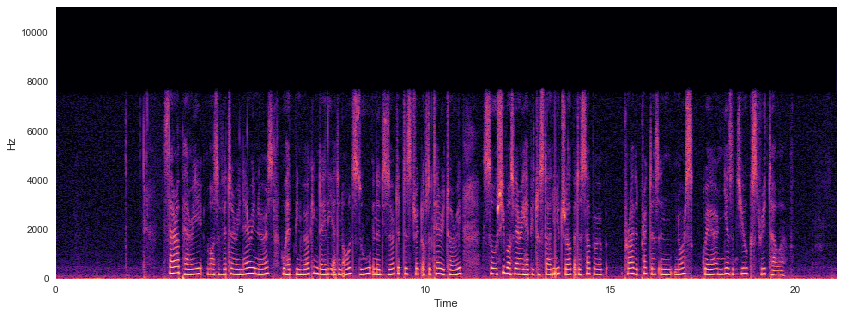

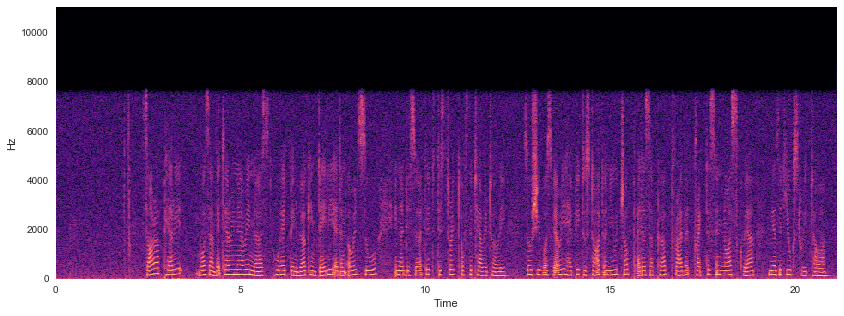

In [49]:
#using librosa to display MFCCs (different parameters may be substituted as needed)
#we are CS students, not signal processing experts

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

x, sr = librosa.load('Desktop/praatscripts/PraatScripts/audio/test_0986.wav')

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

y, sr = librosa.load('Desktop/praatscripts/PraatScripts/audio/test_0775.wav')

Y = librosa.stft(y)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')

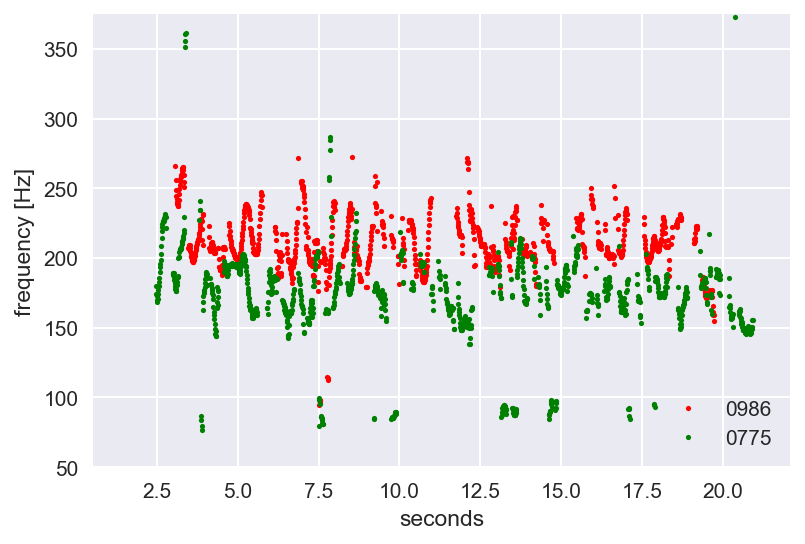

In [48]:
#referenced from https://zuker.io/articles/2019-07/parselmouth-contour

sound0986 = parselmouth.Sound("Desktop/praatscripts/PraatScripts/audio/test_0986.wav")
Audio(data=sound0986.values, rate=sound0986.sampling_frequency) #Mandarin

sound0775 = parselmouth.Sound("Desktop/praatscripts/PraatScripts/audio/test_0775.wav")
Audio(data=sound0775.values, rate=sound0775.sampling_frequency) #English

def plotOnGraph(pitch, color):
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2.5, color=color)
    
def setupGraph(ymin, ymax):
    sns.set() # Use seaborn's default style to make attractive graphs
    plt.rcParams['figure.dpi'] = 150 # Show images nicely
    plt.figure()
    plt.ylim(ymin, ymax)
    plt.ylabel("frequency [Hz]")
    plt.xlabel("seconds")
    plt.grid(True)

pitch0986 = sound0986.to_pitch()
pitch0775 = sound0775.to_pitch()

setupGraph(50, 375)

plotOnGraph(pitch0986, 'r')
plotOnGraph(pitch0775, 'g')

plt.gca().legend(('0986','0775'))

plt.show()


In [51]:
# referenced from https://github.com/drfeinberg/PraatScripts/blob/master/Measure%20Pitch%2C%20HNR%2C%20Jitter%2C%20and%20Shimmer.ipynb

#!/usr/bin/env python3
import glob
import numpy as np
import pandas as pd
import parselmouth 
import statistics


from parselmouth.praat import call
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    duration = call(sound, "Get total duration") # duration
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    
    return duration, meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer

# This function measures formants using Formant Position formula
def measureFormants(sound, wave_file, f0min,f0max):
    sound = parselmouth.Sound(sound) # read the sound
    pitch = call(sound, "To Pitch (cc)", 0, f0min, 15, 'no', 0.03, 0.45, 0.01, 0.35, 0.14, f0max)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    
    formants = call(sound, "To Formant (burg)", 0.0025, 5, 5000, 0.025, 50)
    numPoints = call(pointProcess, "Get number of points")

    f1_list = []
    f2_list = []
    f3_list = []
    f4_list = []
    
    # Measure formants only at glottal pulses
    for point in range(0, numPoints):
        point += 1
        t = call(pointProcess, "Get time from index", point)
        f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f4 = call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
    
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    f2_list = [f2 for f2 in f2_list if str(f2) != 'nan']
    f3_list = [f3 for f3 in f3_list if str(f3) != 'nan']
    f4_list = [f4 for f4 in f4_list if str(f4) != 'nan']
    
    # calculate mean formants across pulses
    f1_mean = statistics.mean(f1_list)
    f2_mean = statistics.mean(f2_list)
    f3_mean = statistics.mean(f3_list)
    f4_mean = statistics.mean(f4_list)
    
    # calculate median formants across pulses, this is what is used in all subsequent calcualtions
    # you can use mean if you want, just edit the code in the boxes below to replace median with mean
    f1_median = statistics.median(f1_list)
    f2_median = statistics.median(f2_list)
    f3_median = statistics.median(f3_list)
    f4_median = statistics.median(f4_list)
    
    return f1_mean, f2_mean, f3_mean, f4_mean, f1_median, f2_median, f3_median, f4_median
def runPCA(df):
    # z-score the Jitter and Shimmer measurements
    measures = ['localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
                'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer']
    x = df.loc[:, measures].values
    x = StandardScaler().fit_transform(x)
    # PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['JitterPCA', 'ShimmerPCA'])
    principalDf
    return principalDf

# create lists to put the results
file_list = []
duration_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []
f1_mean_list = []
f2_mean_list = []
f3_mean_list = []
f4_mean_list = []
f1_median_list = []
f2_median_list = []
f3_median_list = []
f4_median_list = []

# Go through all the wave files in the folder and measure all the acoustics
def getStats(wave_file):
    sound = parselmouth.Sound(wave_file)
    (duration, meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, 
     localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(
        sound, 75, 300, "Hertz")
    (f1_mean, f2_mean, f3_mean, f4_mean, f1_median, f2_median, f3_median, f4_median) = measureFormants(
        sound, wave_file, 75, 300)
    file_list.append(wave_file) # make an ID list
    duration_list.append(duration) # make duration list
    mean_F0_list.append(meanF0) # make a mean F0 list
    sd_F0_list.append(stdevF0) # make a sd F0 list
    hnr_list.append(hnr) #add HNR data
    
    # add raw jitter and shimmer measures
    localJitter_list.append(localJitter)
    localabsoluteJitter_list.append(localabsoluteJitter)
    rapJitter_list.append(rapJitter)
    ppq5Jitter_list.append(ppq5Jitter)
    ddpJitter_list.append(ddpJitter)
    localShimmer_list.append(localShimmer)
    localdbShimmer_list.append(localdbShimmer)
    apq3Shimmer_list.append(apq3Shimmer)
    aqpq5Shimmer_list.append(aqpq5Shimmer)
    apq11Shimmer_list.append(apq11Shimmer)
    ddaShimmer_list.append(ddaShimmer)
    
    # add the formant data
    f1_mean_list.append(f1_mean)
    f2_mean_list.append(f2_mean)
    f3_mean_list.append(f3_mean)
    f4_mean_list.append(f4_mean)
    f1_median_list.append(f1_median)
    f2_median_list.append(f2_median)
    f3_median_list.append(f3_median)
    f4_median_list.append(f4_median)

getStats('Desktop/audioclips/reduced/test_0001.wav')
getStats('Desktop/praatscripts/PraatScripts/audio/test_0775.wav')

# Add the data to Pandas
df = pd.DataFrame(np.column_stack([file_list, duration_list, mean_F0_list, sd_F0_list, hnr_list, 
                                   localJitter_list, localabsoluteJitter_list, rapJitter_list, 
                                   ppq5Jitter_list, ddpJitter_list, localShimmer_list, 
                                   localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, 
                                   apq11Shimmer_list, ddaShimmer_list, f1_mean_list, 
                                   f2_mean_list, f3_mean_list, f4_mean_list, 
                                   f1_median_list, f2_median_list, f3_median_list, 
                                   f4_median_list]),
                                   columns=['voiceID', 'duration', 'meanF0Hz', 'stdevF0Hz', 'HNR', 
                                            'localJitter', 'localabsoluteJitter', 'rapJitter', 
                                            'ppq5Jitter', 'ddpJitter', 'localShimmer', 
                                            'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                            'apq11Shimmer', 'ddaShimmer', 'f1_mean', 'f2_mean', 
                                            'f3_mean', 'f4_mean', 'f1_median', 
                                            'f2_median', 'f3_median', 'f4_median'])

pcaData = runPCA(df) # Run jitter and shimmer PCA
df = pd.concat([df, pcaData], axis=1) # Add PCA data
# reload the data so it's all numbers
df.to_csv("processed_results.csv", index=False)
df = pd.read_csv('processed_results.csv', header=0)
df.sort_values('voiceID').head(20)

df['pF'] = (zscore(df.f1_median) + zscore(df.f2_median) + zscore(df.f3_median) + zscore(df.f4_median)) / 4

df['fdisp'] = (df['f4_median'] - df['f1_median']) / 3

df['avgFormant'] = (df['f1_median'] + df['f2_median'] + df['f3_median'] + df['f4_median']) / 4

df['mff'] = (df['f1_median'] * df['f2_median'] * df['f3_median'] * df['f4_median']) ** 0.25

# reload the data again
df.to_csv("processed_results.csv", index=False)
df = pd.read_csv('processed_results.csv', header=0)

df['fitch_vtl'] = ((1 * (35000 / (4 * df['f1_median']))) +
                   (3 * (35000 / (4 * df['f2_median']))) + 
                   (5 * (35000 / (4 * df['f3_median']))) + 
                   (7 * (35000 / (4 * df['f4_median'])))) / 4

xysum = (0.5 * df['f1_median']) + (1.5 * df['f2_median']) + (2.5 * df['f3_median']) + (3.5 * df['f4_median'])
xsquaredsum = (0.5 ** 2) + (1.5 ** 2) + (2.5 ** 2) + (3.5 ** 2)
df['delta_f'] = xysum / xsquaredsum

df['vtl_delta_f'] = 35000 / (2 * df['delta_f'])

df

,voiceID,duration,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,...,f4_median,JitterPCA,ShimmerPCA,pF,fdisp,avgFormant,mff,fitch_vtl,delta_f,vtl_delta_f
0,Desktop/audioclips/reduced/test_0001.wav,2.786395,236.011010,27.965145,9.230188,0.024141,0.000103,0.010447,0.012591,0.031342,...,3607.209300,-3.316625,3.510833e-16,0.5,970.275477,2038.750195,1703.856613,16.655460,1012.882445,17.277425
1,Desktop/praatscripts/PraatScripts/audio/test_0...,7.662585,243.402781,20.848784,10.650633,0.017886,0.000074,0.005946,0.008205,0.017837,...,3491.705026,3.316625,3.510833e-16,-0.5,950.731192,1963.213592,1642.058363,17.196658,973.272137,17.980583


In [52]:
df.sort_values('voiceID').head(20)

,voiceID,duration,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,...,f4_median,JitterPCA,ShimmerPCA,pF,fdisp,avgFormant,mff,fitch_vtl,delta_f,vtl_delta_f
0,Desktop/audioclips/reduced/test_0001.wav,2.786395,236.011010,27.965145,9.230188,0.024141,0.000103,0.010447,0.012591,0.031342,...,3607.209300,-3.316625,3.510833e-16,0.5,970.275477,2038.750195,1703.856613,16.655460,1012.882445,17.277425
1,Desktop/praatscripts/PraatScripts/audio/test_0...,7.662585,243.402781,20.848784,10.650633,0.017886,0.000074,0.005946,0.008205,0.017837,...,3491.705026,3.316625,3.510833e-16,-0.5,950.731192,1963.213592,1642.058363,17.196658,973.272137,17.980583
